# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Chengdong Huang
*   Student Number: 1000185881

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? **284807** **[0.1]**
* What features in the dataset are present aside from the 28 main features?  **Transaction time and Amount** **[0.1]**
* Which column contains the targets? **Class** **[0.1]**
* To what do the target values correspond? **0 is normal transaction and 1 is fraud_transaction** **[0.1]**

In [215]:
pip install wget

In [216]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (3).gz'

In [217]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [219]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0



* What is the percentage of entries in the dataset for each class? **99.83% normal transaction and 0.173% fraud transaction** **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case? **The data is unbalanced. The amount of target data for Class 0 is much higher than class 1** **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **The balancing or unbalanced dataset has impact on the model to be selected, trained and evaluated. If such unbalanced dataset was given to train a KNN model like project 1, it is likely to develop a basied model as most of the target data class is 0.  ** **[0.2]**



In [220]:
totalclass=df['Class'].values
percentofnormal=np.sum(totalclass==0)/len(totalclass)
percentoffraud=np.sum(totalclass==1)/len(totalclass)
percentoffraud
percentofnormal
print("percentage of normal transactions:", percentofnormal*100,"%" "\n","percentage of frauds:", percentoffraud*100,'%')

percentage of normal transactions: 99.82725143693798 %
 percentage of frauds: 0.1727485630620034 %


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [221]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class',1), df['Class'],test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train,test_size=0.15/0.85, random_state=0)

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

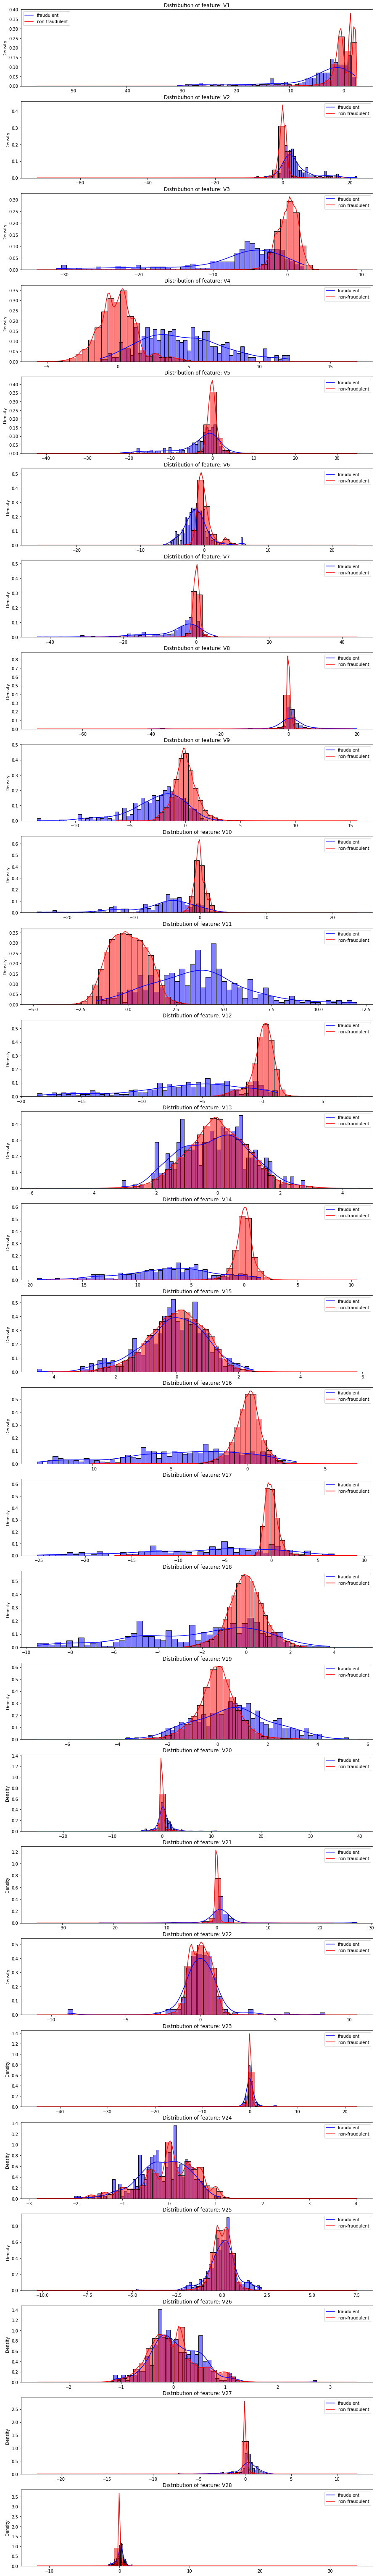

In [222]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

**Answer: It provides many useful information to preliminarily determine the potential AUC for each features:**
1. the density for each class (fraudulent vs. non-fraudulent) for each feature. It can tell us whether the univariate feature for each class is normal distribution or not. If it is more than one peak at the mean, probably we need n_component>1 to fit the gaussian model; 
2. It tells how each class for each feature overlap to each other. For example, Feature 13 and Feature 15, both class are overlapping to each other and that makes our model fit poorly because we can't distinguish a good cutoff. A good feature that having high potential AUC should be like Feature 14 or Feature 17. Those non-fraudulent and fraudulent are distinctly separate.

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





Part 2a. Q1 to Q3 **Training Data set**

In [223]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
gm_train_full = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
#train the model using full dataset and store the values of auc in the array
X_train_array=X_train.values
auc_of_train=np.arange(28,dtype=float)
X_val_array=X_val.values
auc_of_val=np.arange(28,dtype=float)
for i in range(1,29):
  gm_train_full.fit(X_train_array[:,i].reshape(-1,1)) #fit the model using the X_train_array.values 
  p_train_full = gm_train_full.score_samples(X_train_array[:,i].reshape(-1,1)) #compute PDF using training set
  p_val_full=gm_train_full.score_samples(X_val_array[:,i].reshape(-1,1)) #compute PDF using val set
  auc_of_train[i-1]=roc_auc_score(y_train, 1-p_train_full)
  auc_of_val[i-1]=roc_auc_score(y_val, 1-p_val_full)

In [224]:
#contrust the table 
featurename=X_train.drop(['Time',"Amount"],1).columns
table_part2={"AUC Scores - Training":auc_of_train,"AUC Scores - Validation": auc_of_val}
results_part2=pd.DataFrame(table_part2,featurename)
results_part2

,AUC Scores - Training,AUC Scores - Validation
V1,0.704715,0.731833
V2,0.848104,0.837961
V3,0.880042,0.832369
V4,0.894416,0.871487
V5,0.760907,0.816581
V6,0.734653,0.721507
V7,0.862982,0.872639
V8,0.772515,0.828098
V9,0.799795,0.820999
V10,0.911624,0.914375


Part 2a. Q4 - Based on the AUC (potentially good model), the best 3 features are **V14, V12, V17**

In [225]:
results_part2.sort_values(by='AUC Scores - Validation', ascending=False)

,AUC Scores - Training,AUC Scores - Validation
V14,0.949740,0.955297
V12,0.912838,0.928006
V17,0.927538,0.925703
V10,0.911624,0.914375
V16,0.898402,0.913098
V11,0.898589,0.904493
V7,0.862982,0.872639
V4,0.894416,0.871487
V21,0.820612,0.869112
V2,0.848104,0.837961


**Part 2 Q5 - V14 Optimum threshold**

In [226]:
# define a function to return the best threshold values and F1 scores
def call_for_optimum_threshold(pass_string):
  from sklearn.metrics import f1_score
  gm_part2a=GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  #Data preparation by only keeping the selected feature column, i.e., V14 or V12 depending on the what values passed to the function
  X_val_part2a=X_val[pass_string]
  y_val_array=y_val.values
  X_train_part2a=X_train[pass_string]
  #compute the gm and likehood for selected featured and sorted the likelihood p
  gm_part2a.fit(X_train_part2a.values.reshape(-1,1))   #fit the model with training data
  p_part2a=gm_part2a.score_samples(X_val_part2a.values.reshape(-1,1)) #compute the p using the validation set
  p_part2a_sorted=np.sort(p_part2a)
  F1_score_part2a=np.zeros(100,dtype=float)      #define a F1_score array to store the data; every time when we call the function the vaules will reset to 0
  for j in range(0,100,1):                      #for loop to try values in one step from 0 to 100 of the sorted values 
    threshold_temp=p_part2a_sorted[j]  # the reason of selecting the 0 to 100 is because at there are only 355 fradulent transaction and F1 socres will converges even though at the 75th of sorted values (based on observation)
    F1_score_part2a[j]=f1_score(y_val_array,p_part2a<threshold_temp) 
  position=F1_score_part2a.argmax()         
  maximized_F1=max(F1_score_part2a)
  threshold_part2a=p_part2a_sorted[position]
  return position,maximized_F1,threshold_part2a


In [227]:
selected_feature='V14'
info1,info2,info3=call_for_optimum_threshold(selected_feature)
print("the Highest F1 occurs in the",info1, "th value of F1_score array, which is ",info2,
      ".The corresponding threshold is",info3)

the Highest F1 occurs in the 56 th value of F1_score array, which is  0.6218487394957983 .The corresponding threshold is -23.083734928584178


**V17 Optimum threshold**

In [228]:
selected_feature='V17'
info4,info5,info6=call_for_optimum_threshold(selected_feature)
print("the Highest F1 occurs in the",info4, "th value of F1_score array, which is ",info5,
      ".The corresponding threshold is",info6)

the Highest F1 occurs in the 51 th value of F1_score array, which is  0.5614035087719298 .The corresponding threshold is -21.823881250748027


**V12 Optimum threshold**

In [229]:
selected_feature='V12'
info7,info8,info9=call_for_optimum_threshold(selected_feature)
print("the Highest F1 occurs in the",info7, "th value of F1_score array, which is ",info8,
      ".The corresponding threshold is",info9)

the Highest F1 occurs in the 42 th value of F1_score array, which is  0.6285714285714286 .The corresponding threshold is -12.154129808866921


**Part 2a.Q6** Followings are the element operation of the call function(call_for_optimum_threshold)
1. Copying the values to X_val_part2a and X_train_part2a: linear and it depends on the n-size: 0.15*n+0.7*n (70% training and 15%validation)
2. fit the model using training set:  linear and it depends on the n-size: 0.7*n
3. compute the pdf using the validation set: linear and it depends on the n-size: 0.15*n
4. sorted the array: assuming using the quicksort method and the average time is 0.15n*log(0.15n)
5. a 100-times for-loop is independent of input size. However, it does two-times comparision (p less than threshold and compare to y-true): 0.15n*2
6. find the maximum in an 100x1 array: idependent of the input size.
7. Conlusion the Big O (sum of 1 to 6)is: 2n+0.15n*log(0.15n)

**Part 2b. Non-fraudulent class only**

In [230]:
#prepare the dataset by removing all Class=1 for **TRAINING** dataset
X_train_withclass=X_train
X_train_withclass["Class"]=y_train
X_train_nonfraud=X_train_withclass[X_train_withclass['Class']==0] #note this is the entire feature columns including Class
y_train_nonfraud=X_train_nonfraud["Class"]

In [231]:
def call_for_optimum_threshold_2b(pass_string):
  from sklearn.metrics import f1_score
  gm_part2b=GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  #same as Part2a function. But this time the training data has removed the fraudulent data 
  X_val_part2b=X_val[pass_string]
  y_val_array=y_val.values
  X_train_part2b=X_train_nonfraud[pass_string]  #the training set is the only one difference that the first call function
  #compute the gm and likehood for selected featured and sorted the likelihood p
  gm_part2b.fit(X_train_part2b.values.reshape(-1,1))   #fit the model with **TRAINING** data with "NON-FRAUDULENT DATA" ONLY
  p_part2b=gm_part2b.score_samples(X_val_part2b.values.reshape(-1,1)) #compute the p using the validation set. "NO CLASS REMOVING FOR VALIDATION SET"
  p_part2b_sorted=np.sort(p_part2b)
  auc_of_val_part2b=roc_auc_score(y_val,1-p_part2b)
  F1_score_part2b=np.zeros(100,dtype=float)      #define a F1_score array to store the data; every time when we call the function the vaules will reset to 0
  for j in range(0,100,1):                      #for loop to try values in one step from 0 to 100 of the sorted values 
    threshold_temp=p_part2b_sorted[j]  # the reason of selecting the 0 to 100 is because at there are only 355 fradulent transaction and F1 socres will converges even though at the 75th of sorted values (based on observation)
    F1_score_part2b[j]=f1_score(y_val_array,p_part2b<threshold_temp) 
  position=F1_score_part2b.argmax()         
  maximized_F1=max(F1_score_part2b)
  threshold_part2b=p_part2b_sorted[position]
  return position,maximized_F1,threshold_part2b,auc_of_val_part2b

**V14 Optimum threshold - Non Fraudulent Class Only**

In [232]:
selected_feature_part2b='V14'
info10,info11,info12,info13=call_for_optimum_threshold_2b(selected_feature_part2b)
print("the Highest F1 occurs in the",info10, "th value of F1_score array, which is ",info11,
      "\nThe corresponding threshold is",info12,". The AUC score is ",info13)

the Highest F1 occurs in the 56 th value of F1_score array, which is  0.6218487394957983 
The corresponding threshold is -26.08433773803603 . The AUC score is  0.9560613874693298


**V17 Optimum threshold - Non Fraudulent Class Only**

In [233]:
selected_feature_part2b='V17'
info14,info15,info16,info17=call_for_optimum_threshold_2b(selected_feature_part2b)
print("the Highest F1 occurs in the",info14, "th value of F1_score array, which is ",info15,
      "\nThe corresponding threshold is",info16,". The AUC score is ",info17)

the Highest F1 occurs in the 51 th value of F1_score array, which is  0.5614035087719298 
The corresponding threshold is -27.768574194302523 . The AUC score is  0.9264757647944858


**V12 Optimum threshold - Non Fraudulent Class Only**

In [234]:
selected_feature_part2b='V12'
info18,info19,info20,info21=call_for_optimum_threshold_2b(selected_feature_part2b)
print("the Highest F1 occurs in the",info18, "th value of F1_score array, which is ",info19,
      "\nThe corresponding threshold is",info20,". The AUC score is ",info21)

the Highest F1 occurs in the 42 th value of F1_score array, which is  0.6285714285714286 
The corresponding threshold is -13.476823057331078 . The AUC score is  0.9283701228002414


**Part 2b. Q3 Table for result of AUC and F1**

In [235]:
result_data={'AUC-Both Class Fit(computed by Validation_set)':[results_part2.iloc[14-1,1],results_part2.iloc[17-1,1],results_part2.iloc[12-1,1]],
             'F1-Both Class Fit(computed by Validation_set)':[info2,info5,info8],
             'AUC-Non fraudulent Fit(computed by Validation_set)':[info13,info17,info21],
             'F1-Non fraudulent Fit(computed by Validation_set)':[info11,info15,info19]}

In [236]:
result_table=pd.DataFrame(result_data,index=['V14','V17',"V12"])
result_table

,AUC-Both Class Fit(computed by Validation_set),F1-Both Class Fit(computed by Validation_set),AUC-Non fraudulent Fit(computed by Validation_set),F1-Non fraudulent Fit(computed by Validation_set)
V14,0.955297,0.621849,0.956061,0.621849
V17,0.925703,0.561404,0.926476,0.561404
V12,0.928006,0.628571,0.928370,0.628571


**Part 2b.Q4 Answer**
Based on the table above. The results for two models (one fit with Full Class Training Data while the other fit with Only Non-Fraudulent data) of computing F1 and AUC are pretty much the same. This is because the for the same dataset with single feature, the outliers are not the dominanted factor for the entire dataset. So the outcome of the gaussian model using two class fit will not affect that much by outliers' influence (i.e. unbalancing data). Thus, the PDF under each fit will not variate that much.

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





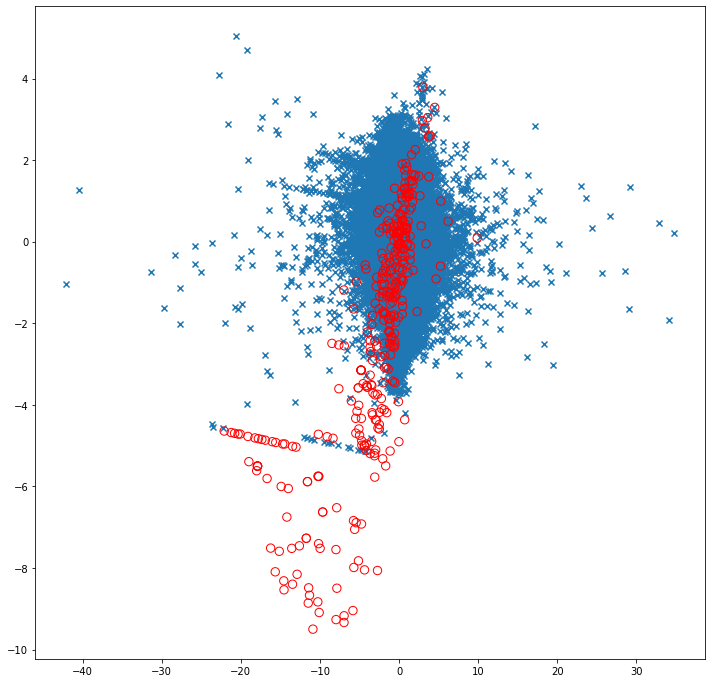

In [237]:
X_train_two=pd.DataFrame(X_train,columns=["V5","V18"])
X_train_two["Class"]=y_train
X_val_two=pd.DataFrame(X_val,columns=["V5","V18"])
X_val_two["Class"]=y_val
plt.figure(figsize=(12,12))
nonoutliers = np.nonzero(X_train_two.values[:,2]==0)[0]
plt.scatter(X_train_two.values[nonoutliers,0],X_train_two.values[nonoutliers,1],marker="x");
outliers = np.nonzero(X_train_two.values[:,2]==1)[0]
store_1=plt.scatter(X_train_two.values[outliers,0],X_train_two.values[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show(store_1)

**Part 3. Q4**
Since the scatter plot is not easy to visualize the density. A histogram below is employed to show there are three (n_componets should be 3) main clusters (0 is being the first feature and 1 means the second feature)

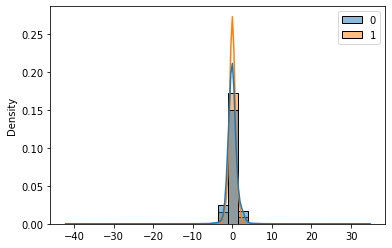

In [238]:
# only plot with the non-fraudulent data and see the density. Legend 0 is the 1st feature and Legend 1 is the second feature
store_2=sns.histplot(X_train_two.values[nonoutliers,:-1], stat="density", kde=True,color="blue",bins=30,legend=True)
plt.show(store_2)

In [239]:
#Computing the AUC for Training and Validation Set
gm_two_features_train = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0, )
gm_two_features_train.fit(X_train_two.drop(columns='Class').values)
p_train_two_features = gm_two_features_train.score_samples(X_train_two.drop(columns='Class').values)
p_val_two_features = gm_two_features_train.score_samples(X_val_two.drop(columns='Class').values)
auc_train_twofeatures=roc_auc_score(y_train, 1-p_train_two_features)
auc_val_twofeatures=roc_auc_score(y_val, 1-p_val_two_features)
data_two_feature={'Training Data for V5 and V18':[auc_train_twofeatures],'Validation Data for V5 and V18':[auc_val_twofeatures]}
result_table2=pd.DataFrame(data_two_feature,index=["AUC Score"])
result_table2

,Training Data for V5 and V18,Validation Data for V5 and V18
AUC Score,0.811412,0.820702


**Pair 1**

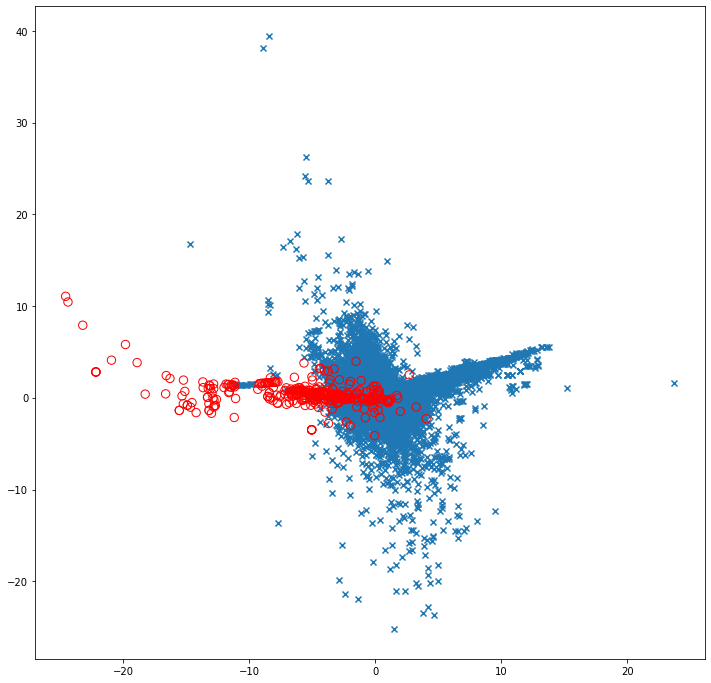

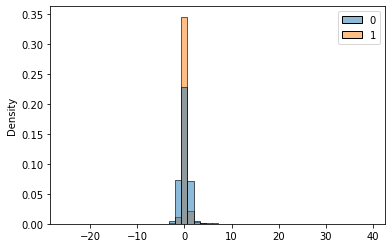

In [240]:
X_train_pair1=pd.DataFrame(X_train,columns=["V10","V20"])
X_train_pair1["Class"]=y_train
X_val_pair1=pd.DataFrame(X_val,columns=["V10","V20"])
X_val_pair1["Class"]=y_val
plt.figure(figsize=(12,12))
nonoutliers_pair1 = np.nonzero(X_train_pair1.values[:,2]==0)[0]
plt.scatter(X_train_pair1.values[nonoutliers_pair1,0],X_train_pair1.values[nonoutliers_pair1,1],marker="x");
outliers_pair1 = np.nonzero(X_train_pair1.values[:,2]==1)[0]
plt.scatter(X_train_pair1.values[outliers_pair1,0],X_train_pair1.values[outliers_pair1,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()
sns.histplot(X_train_pair1.values[nonoutliers_pair1,:-1], stat="density",color="blue",bins=50,legend=True)
plt.show()

In [241]:
gm_pair1 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0, ) # the above results show should be 3
gm_pair1.fit(X_train_pair1.drop(columns='Class').values)
p_train_pair1 = gm_pair1.score_samples(X_train_pair1.drop(columns='Class').values)
p_val_pair1 = gm_pair1.score_samples(X_val_pair1.drop(columns='Class').values)
auc_train_pair1=roc_auc_score(y_train, 1-p_train_pair1)
auc_val_pair1=roc_auc_score(y_val, 1-p_val_pair1)
data_two_feature_1={'Training Data for V10 and V20':[auc_train_pair1],'Validation Data for V10 and V20':[auc_val_pair1]}
result_pair1=pd.DataFrame(data_two_feature_1,index=["AUC Score"])
result_pair1

,Training Data for V10 and V20,Validation Data for V10 and V20
AUC Score,0.928672,0.92723


**Pair 2**

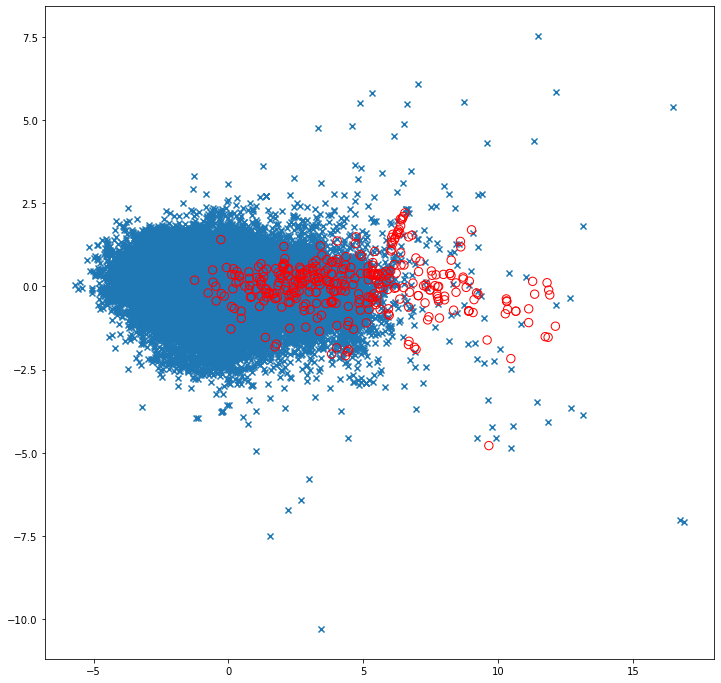

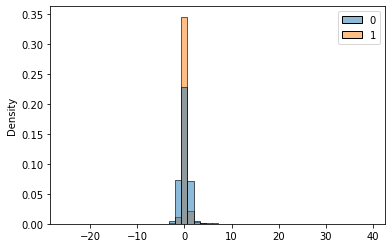

In [242]:
X_train_pair2=pd.DataFrame(X_train,columns=["V4","V25"])
X_train_pair2["Class"]=y_train
X_val_pair2=pd.DataFrame(X_val,columns=["V4","V25"])
X_val_pair2["Class"]=y_val
plt.figure(figsize=(12,12))
nonoutliers_pair2 = np.nonzero(X_train_pair2.values[:,2]==0)[0]
plt.scatter(X_train_pair2.values[nonoutliers_pair2,0],X_train_pair2.values[nonoutliers_pair2,1],marker="x");
outliers_pair2 = np.nonzero(X_train_pair2.values[:,2]==1)[0]
plt.scatter(X_train_pair2.values[outliers_pair2,0],X_train_pair2.values[outliers_pair2,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()
sns.histplot(X_train_pair1.values[nonoutliers_pair2,:-1], stat="density",color="blue",bins=50,legend=True)
plt.show()

In [243]:
gm_pair2 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0, ) # the above results show should be 3
gm_pair2.fit(X_train_pair2.drop(columns='Class').values)
p_train_pair2 = gm_pair2.score_samples(X_train_pair2.drop(columns='Class').values)
p_val_pair2 = gm_pair2.score_samples(X_val_pair2.drop(columns='Class').values)
auc_train_pair2=roc_auc_score(y_train, 1-p_train_pair2)
auc_val_pair2=roc_auc_score(y_val, 1-p_val_pair2)
data_two_feature_2={'Training Data for V4 and V25':[auc_train_pair2],'Validation Data for V4 and V25':[auc_val_pair2]}
result_pair2=pd.DataFrame(data_two_feature_2,index=["AUC Score"])
result_pair2

,Training Data for V4 and V25,Validation Data for V4 and V25
AUC Score,0.885833,0.871491


**Pair3**

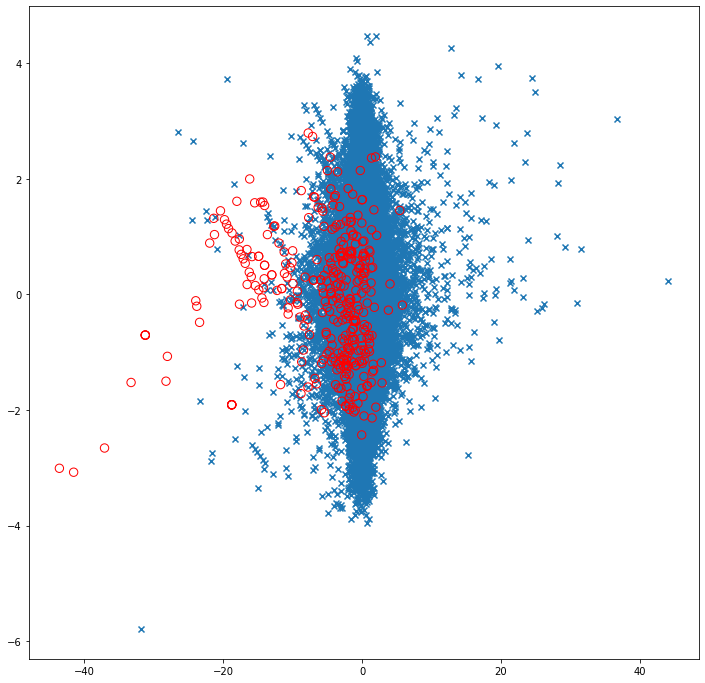

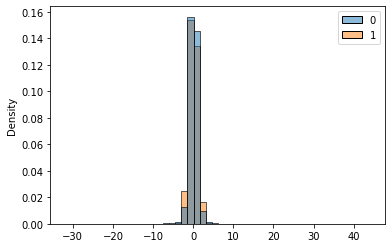

In [244]:
X_train_pair3=pd.DataFrame(X_train,columns=["V7","V13"])
X_train_pair3["Class"]=y_train
X_val_pair3=pd.DataFrame(X_val,columns=["V7","V13"])
X_val_pair3["Class"]=y_val
plt.figure(figsize=(12,12))
nonoutliers_pair3 = np.nonzero(X_train_pair3.values[:,2]==0)[0]
plt.scatter(X_train_pair3.values[nonoutliers_pair3,0],X_train_pair3.values[nonoutliers_pair3,1],marker="x");
outliers_pair3 = np.nonzero(X_train_pair3.values[:,2]==1)[0]
plt.scatter(X_train_pair3.values[outliers_pair3,0],X_train_pair3.values[outliers_pair3,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()
sns.histplot(X_train_pair3.values[nonoutliers_pair3,:-1], stat="density",color="blue",bins=50,legend=True)
plt.show()

In [245]:
gm_pair3 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0, ) # the above results show should be 4
gm_pair3.fit(X_train_pair3.drop(columns='Class').values)
p_train_pair3 = gm_pair3.score_samples(X_train_pair3.drop(columns='Class').values)
p_val_pair3 = gm_pair3.score_samples(X_val_pair3.drop(columns='Class').values)
auc_train_pair3=roc_auc_score(y_train, 1-p_train_pair3)
auc_val_pair3=roc_auc_score(y_val, 1-p_val_pair3)
data_two_feature_3={'Training Data for V7 and V13':[auc_train_pair3],'Validation Data for V7 and V13':[auc_val_pair3]}
result_pair3=pd.DataFrame(data_two_feature_3,index=["AUC Score"])
result_pair3

,Training Data for V7 and V13,Validation Data for V7 and V13
AUC Score,0.862933,0.886618


In [246]:
# define other function (input is selected feature and n component based on the visualized plots), return the threshold
def call_for_optimum_threshold_3(pass_string,components):
  from sklearn.metrics import f1_score
  gm_part3=GaussianMixture(n_components = components, covariance_type = 'full', random_state=0, )
  #Data preparation by only keeping the selected feature column, i.e., V14 or V12 depending on the what values passed to the function
  X_val_part3=X_val[pass_string]
  y_val_array=y_val.values
  X_train_part3=X_train[pass_string]
  #compute the gm and likehood for selected featured and sorted the likelihood p
  gm_part3.fit(X_train_part3.values)   #fit the model with training data
  p_part3=gm_part3.score_samples(X_val_part3.values) #compute the p using the validation set
  p_part3_sorted=np.sort(p_part3)
  F1_score_part3=np.zeros(300,dtype=float)      #define a F1_score array to store the data; every time when we call the function the vaules will reset to 0
  for j in range(0,300,1):                      #for loop to try values in one step from 0 to 100 of the sorted values 
    threshold_temp=p_part3_sorted[j]  # the reason of selecting the 0 to 100 is because at there are only 355 fradulent transaction and F1 socres will converges even though at the 75th of sorted values (based on observation)
    F1_score_part3[j]=f1_score(y_val_array,p_part3<threshold_temp) 
  position=F1_score_part3.argmax()         
  maximized_F1=max(F1_score_part3)
  threshold_part3=p_part3_sorted[position]
  return position,maximized_F1,threshold_part3

In [247]:
# for Pair 1
pass_feature_pair1=['V10',"V20"]
info1_pair1,info2_pair1,info3_pair1=call_for_optimum_threshold_3(pass_feature_pair1,3) # from previous step for pair 1
print("the Highest F1 occurs in the",info1_pair1, "th value of F1_score array, which is ",info2_pair1,
     ".The corresponding threshold is",info3_pair1)

the Highest F1 occurs in the 30 th value of F1_score array, which is  0.21505376344086022 .The corresponding threshold is -13.415616622415799


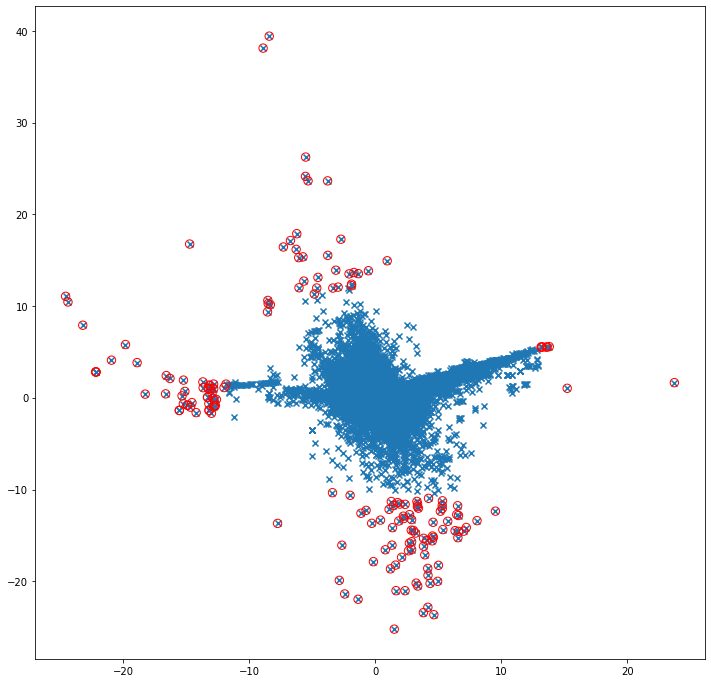

In [248]:
plt.figure(figsize=(12,12))
plt.scatter(X_train_pair1.values[:,0],X_train_pair1.values[:,1],marker="x");  #plot all data points, including outlier
outliers_pair1_threshold = np.nonzero(p_train_pair1<info3_pair1)[0] #define a outlier using the threshold
plt.scatter(X_train_pair1.values[outliers_pair1_threshold,0],X_train_pair1.values[outliers_pair1_threshold,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

In [249]:
# for Pair 2
pass_feature_pair2=['V4',"V25"]
info1_pair2,info2_pair2,info3_pair2=call_for_optimum_threshold_3(pass_feature_pair2,3) # from previous step for pair 2
print("the Highest F1 occurs in the",info1_pair2, "th value of F1_score array, which is ",info2_pair2,
     ".The corresponding threshold is",info3_pair2)

the Highest F1 occurs in the 94 th value of F1_score array, which is  0.15286624203821655 .The corresponding threshold is -9.770339036549226


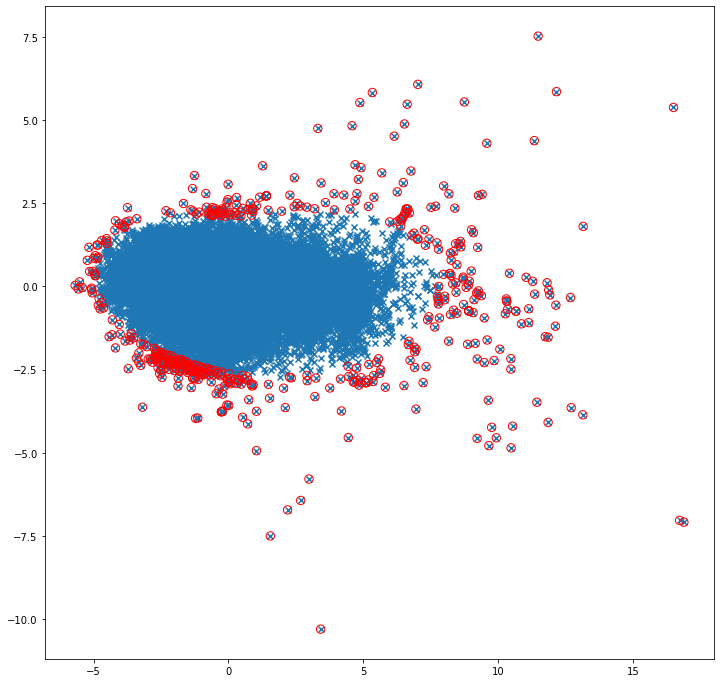

In [250]:
plt.figure(figsize=(12,12))
plt.scatter(X_train_pair2.values[:,0],X_train_pair2.values[:,1],marker="x");  #plot all data points, including outlier
outliers_pair2_threshold = np.nonzero(p_train_pair2<info3_pair2)[0] #define a outlier using the threshold
plt.scatter(X_train_pair2.values[outliers_pair2_threshold,0],X_train_pair2.values[outliers_pair2_threshold,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

In [251]:
# for Pair 3
pass_feature=['V7',"V13"]
info1_pair3,info2_pair3,info3_pair3=call_for_optimum_threshold_3(pass_feature,4) # from previous step for pair 3
print("the Highest F1 occurs in the",info1_pair3, "th value of F1_score array, which is ",info2_pair3,
     ".The corresponding threshold is",info3_pair3)

the Highest F1 occurs in the 83 th value of F1_score array, which is  0.2328767123287671 .The corresponding threshold is -9.68587971482015


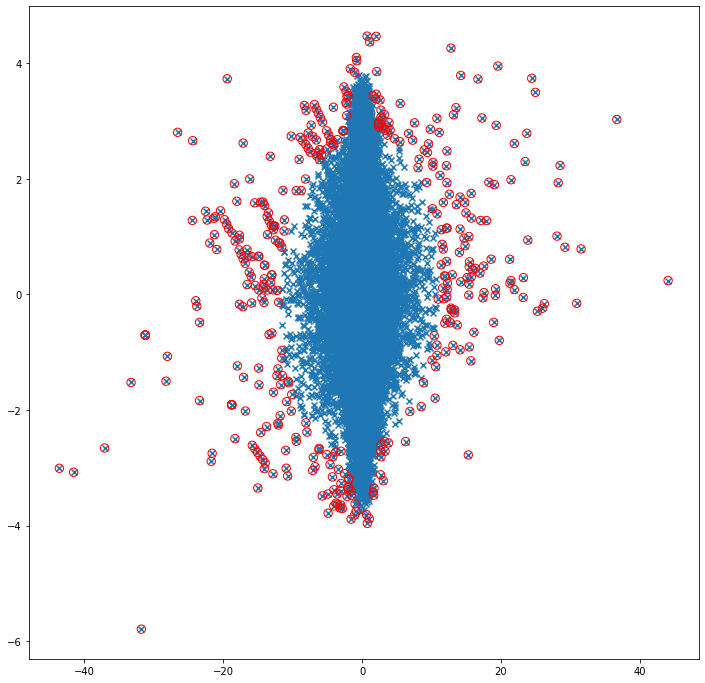

In [252]:
plt.figure(figsize=(12,12))
plt.scatter(X_train_pair3.values[:,0],X_train_pair3.values[:,1],marker="x");  #plot all data points, including outlier
outliers_pair3_threshold = np.nonzero(p_train_pair3<info3_pair3)[0] #define a outlier using the threshold
plt.scatter(X_train_pair3.values[outliers_pair3_threshold,0],X_train_pair3.values[outliers_pair3_threshold,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [253]:
g1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
g2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
enumerate_list=enumerate(X_train.drop(columns=["Time","Amount","Class"]).columns)

In [254]:
#Data prepare for feature V
from sklearn.metrics import f1_score
F1_score_best=np.zeros(28,dtype=float)
F1_score_best_train=np.zeros(28,dtype=float)
c_best=np.zeros(28,dtype=float)
c_best_train=np.zeros(28,dtype=float)

for i in range (0,28):
  enumerate_list=enumerate(X_train.drop(columns=["Time","Amount","Class"]).columns)
  v_feature_name=list(enumerate_list)[i][1]
  dataframe_Vx_train=pd.DataFrame(X_train,columns=[v_feature_name,"Class"])
  X_train_nonfraud_part4=dataframe_Vx_train[dataframe_Vx_train['Class']==0]
  X_train_fraud_part4=dataframe_Vx_train[dataframe_Vx_train['Class']==1]
  #fit the model with training set and compute the score with the validation set
  g1.fit(X_train_nonfraud_part4.drop(columns='Class').values)
  g2.fit(X_train_fraud_part4.drop(columns='Class').values)
  s1=g1.score_samples(X_val[v_feature_name].values.reshape(-1,1))
  s2=g2.score_samples(X_val[v_feature_name].values.reshape(-1,1))
  s1_train=g1.score_samples(X_train[v_feature_name].values.reshape(-1,1))
  s2_train=g2.score_samples(X_train[v_feature_name].values.reshape(-1,1))
  F1_score_part4=np.zeros(100,dtype=float)
  F1_score_part4_train=np.zeros(100,dtype=float)
  k=0
  for c in np.linspace(0,10,100,endpoint=False):
    F1_score_part4[k]=f1_score(y_val,s1<s2*c)
    k+=1
  F1_score_best[i]=max(F1_score_part4)
  c_best[i]=F1_score_part4.argmax()/10

  j=0
  for c in np.linspace(0,10,100,endpoint=False):
    F1_score_part4_train[j]=f1_score(y_train,s1_train<s2_train*c)
    j+=1
  F1_score_best_train[i]=max(F1_score_part4_train)
  c_best_train[i]=F1_score_part4_train.argmax()/10


In [255]:
part4_results={"Best F1 Score(Validation)":F1_score_best,"Best C(Validation)":c_best,"Best F1 Score(Training)":F1_score_best_train,"Best C(Training)":c_best_train}
table_part4=pd.DataFrame(part4_results,index=[featurename])
table_part4

,Best F1 Score(Validation),Best C(Validation),Best F1 Score(Training),Best C(Training)
V1,0.141593,8.1,0.144681,6.7
V2,0.177215,5.9,0.166259,6.1
V3,0.304762,8.2,0.292011,5.1
V4,0.366972,5.0,0.371658,4.2
V5,0.209524,8.5,0.179661,8.2
V6,0.123596,2.2,0.110236,1.8
V7,0.274809,9.8,0.244118,9.5
V8,0.100000,9.2,0.088384,9.9
V9,0.484211,3.3,0.418426,3.1
V10,0.469388,8.0,0.414873,8.0


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

**It makes sense since the non-fraudulent density function are normal distribution with one main cluster based on the Part 1 (pretty much all non-fraudulent are normal distribution with mean is equal to 0). On the other hand, though fraudulent are somewhat normal distribution but apparently the curves are more flat and the height of each bins are pretty much the same (i.e., the sigma is higher, and therefore, more than 1 cluster)**

Summary
1. model 1: Feature =9 (AUC>0.85 in part 2), G=1, n_component=1
2. model 2: Feature =9 (AUC>0.85 in part 2), G=1, n_component>1 *depending on the tunning. (e.g. try different n)
3. model 3: Feature =9 (AUC>0.85 in part 2), G=2, n_component=1 for G1 and G2
4. model 4: Feature =9 (AUC>0.85 in part 2), G=2, n_component=1 for G1 and n>1 for G2
5. model 5: Feature =9 (AUC>0.85 in part 2), G=2, n_component>1 for G1 and G2 && not equal to each other
6. model 6: Feature =6 (AUC>0.9 in part 2), G=1, n_component=1
7. model 7: Feature =6 (AUC>0.9 in part 2), G=1, n_component>1  *depending on the tunning. (e.g. try different n)
8. model 8: Feature =6 (AUC>0.9 in part 2), G=2, n_component=1 for G1 and G2
9. model 9: Feature =6 (AUC>0.9 in part 2), G=2, n_component=1 for G1 and n>1 for G2
10. model 10: Feature =6 (AUC>9 in part 2), G=2, n_component>1 for G1 and G2 && not equal to each other

In [256]:
# define other function to return the F1 for training set
def call_for_optimum_threshold_4(pass_string,components):
  from sklearn.metrics import f1_score
  gm_part3=GaussianMixture(n_components = components, covariance_type = 'full', random_state=0, )
  #Data preparation by only keeping the selected feature column, i.e., V14 or V12 depending on the what values passed to the function
  #X_val_part3=X_val[pass_string]
  y_train_array=y_train.values
  X_train_part3=X_train[pass_string]
  #compute the gm and likehood for selected featured and sorted the likelihood p
  gm_part3.fit(X_train_part3.values)   #fit the model with training data
  p_part3=gm_part3.score_samples(X_train_part3.values) #compute the p using the validation set
  p_part3_sorted=np.sort(p_part3)
  F1_score_part3=np.zeros(300,dtype=float)      #define a F1_score array to store the data; every time when we call the function the vaules will reset to 0
  for j in range(0,300,1):                      #for loop to try values in one step from 0 to 100 of the sorted values 
    threshold_temp=p_part3_sorted[j]  # the reason of selecting the 0 to 100 is because at there are only 355 fradulent transaction and F1 socres will converges even though at the 75th of sorted values (based on observation)
    F1_score_part3[j]=f1_score(y_train_array,p_part3<threshold_temp)         
  maximized_F1=max(F1_score_part3)
  return maximized_F1

In [257]:
#Model 1
gm_model_1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
X_train_model_1=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21'])
X_val_model_1=pd.DataFrame(X_val,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21'])
gm_model_1.fit(X_train_model_1.values)
p_model_1=gm_model_1.score_samples(X_val_model_1.values)
p_model_1_train=gm_model_1.score_samples(X_train_model_1.values)
auc_val_model_1=roc_auc_score(y_val, 1-p_model_1)
auc_train_model_1=roc_auc_score(y_train, 1-p_model_1_train)
model_1_pass=['V14','V12','V17','V10','V16','V11','V7','V4','V21']
info1_model_1,info2_model_1,info3_model_1=call_for_optimum_threshold_3(model_1_pass,1) 
info2_model_1_train=call_for_optimum_threshold_4(model_1_pass,1)
print("the Highest F1 occurs in the",info1_model_1, "th value of F1_score array, which is ",info2_model_1,
     ".The corresponding threshold is",info3_model_1)

the Highest F1 occurs in the 78 th value of F1_score array, which is  0.43971631205673756 .The corresponding threshold is -122.98728142677285


In [258]:
# Model 2
X_train_model_2=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21'])
X_train_model_2["Class"]=y_train
X_val_model_2=pd.DataFrame(X_val,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21'])
X_val_model_2["Class"]=y_val
gm_model_2 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0, ) 
gm_model_2.fit(X_train_model_2.drop(columns='Class').values)
p_model_2 = gm_model_2.score_samples(X_val_model_2.drop(columns='Class').values)
p_model_2_train = gm_model_2.score_samples(X_train_model_2.drop(columns='Class').values)
auc_val_model_2=roc_auc_score(y_val, 1-p_model_2)
auc_train_model_2=roc_auc_score(y_train, 1-p_model_2_train)
model_2_pass=['V14','V12','V17','V10','V16','V11','V7','V4','V21']
info1_model_2,info2_model_2,info3_model_2=call_for_optimum_threshold_3(model_2_pass,3) 
info2_model_2_train=call_for_optimum_threshold_4(model_2_pass,3)
print("the Highest F1 occurs in the",info1_model_2, "th value of F1_score array, which is ",info2_model_2,
     ".The corresponding threshold is",info3_model_2)

the Highest F1 occurs in the 33 th value of F1_score array, which is  0.4166666666666667 .The corresponding threshold is -46.29736899242522


In [259]:
#Model 3
g1_model_3 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
g2_model_3 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

model_3_pass=['V14','V12','V17','V10','V16','V11','V7','V4','V21']
dataframe_model_3=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21',"Class"])
X_train_nonfraud_model_3=dataframe_model_3[dataframe_model_3['Class']==0]
X_train_fraud_model_3=dataframe_model_3[dataframe_model_3['Class']==1]
g1_model_3.fit(X_train_nonfraud_model_3.drop(columns='Class').values)
g2_model_3.fit(X_train_fraud_model_3.drop(columns='Class').values)
s1_model_3=g1_model_3.score_samples(X_val[model_3_pass].values)
s2_model_3=g2_model_3.score_samples(X_val[model_3_pass].values)
s1_model_3_train=g1_model_3.score_samples(X_train[model_3_pass].values)
s2_model_3_train=g2_model_3.score_samples(X_train[model_3_pass].values)
F1_score_model_3=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_3[k]=f1_score(y_val,s1_model_3<s2_model_3*c)
    k+=1
F1_model_3=max(F1_score_model_3)
c_model_3=F1_score_model_3.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_3[j]=f1_score(y_train,s1_model_3_train<s2_model_3_train*c)
    j+=1
F1_model_3_train=max(F1_score_model_3)

print("the Highest F1 occurs is",F1_model_3)

the Highest F1 occurs is 0.7226890756302521


In [260]:
#Model 4
g1_model_4 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
g2_model_4 = GaussianMixture(n_components = 6, covariance_type = 'full', random_state=0, )

model_4_pass=['V14','V12','V17','V10','V16','V11','V7','V4','V21']
dataframe_model_4=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21',"Class"])
X_train_nonfraud_model_4=dataframe_model_4[dataframe_model_4['Class']==0]
X_train_fraud_model_4=dataframe_model_4[dataframe_model_4['Class']==1]
g1_model_4.fit(X_train_nonfraud_model_4.drop(columns='Class').values)
g2_model_4.fit(X_train_fraud_model_4.drop(columns='Class').values)
s1_model_4=g1_model_4.score_samples(X_val[model_4_pass].values)
s2_model_4=g2_model_4.score_samples(X_val[model_4_pass].values)
s1_model_4_train=g1_model_4.score_samples(X_train[model_4_pass].values)
s2_model_4_train=g2_model_4.score_samples(X_train[model_4_pass].values)
F1_score_model_4=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_4[k]=f1_score(y_val,s1_model_4<s2_model_4*c)
    k+=1
F1_model_4=max(F1_score_model_4)
c_model_4=F1_score_model_4.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_4[j]=f1_score(y_train,s1_model_4_train<s2_model_4_train*c)
    j+=1
F1_model_4_train=max(F1_score_model_4)

print("the Highest F1 occurs is",F1_model_4)

the Highest F1 occurs is 0.8225806451612904


In [261]:
#Model 5
g1_model_5 = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0, )
g2_model_5 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0, )

model_5_pass=['V14','V12','V17','V10','V16','V11','V7','V4','V21']
dataframe_model_5=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11','V7','V4','V21',"Class"])
X_train_nonfraud_model_5=dataframe_model_5[dataframe_model_5['Class']==0]
X_train_fraud_model_5=dataframe_model_5[dataframe_model_5['Class']==1]
g1_model_5.fit(X_train_nonfraud_model_5.drop(columns='Class').values)
g2_model_5.fit(X_train_fraud_model_5.drop(columns='Class').values)
s1_model_5=g1_model_5.score_samples(X_val[model_5_pass].values)
s2_model_5=g2_model_5.score_samples(X_val[model_5_pass].values)
s1_model_5_train=g1_model_5.score_samples(X_train[model_5_pass].values)
s2_model_5_train=g2_model_5.score_samples(X_train[model_5_pass].values)
F1_score_model_5=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_5[k]=f1_score(y_val,s1_model_5<s2_model_5*c)
    k+=1
F1_model_5=max(F1_score_model_5)
c_model_5=F1_score_model_5.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_5[j]=f1_score(y_train,s1_model_5_train<s2_model_5_train*c)
    j+=1
F1_model_5_train=max(F1_score_model_5)

print("the Highest F1 occurs is",F1_model_5)

the Highest F1 occurs is 0.819672131147541


In [262]:
# Model 6
gm_model_6 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
X_train_model_6=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11'])
X_val_model_6=pd.DataFrame(X_val,columns=['V14','V12','V17','V10','V16','V11'])
gm_model_6.fit(X_train_model_6.values)
p_model_6=gm_model_6.score_samples(X_val_model_6.values)
p_model_6_train=gm_model_6.score_samples(X_train_model_6.values)
auc_val_model_6=roc_auc_score(y_val, 1-p_model_6)
auc_train_model_6=roc_auc_score(y_train, 1-p_model_6_train)
model_6_pass=['V14','V12','V17','V10','V16','V11']
info1_model_6,info2_model_6,info3_model_6=call_for_optimum_threshold_3(model_6_pass,1) # from previous step for pair 1
info2_model_6_train=call_for_optimum_threshold_4(model_6_pass,1)
print("the Highest F1 occurs in the",info1_model_6, "th value of F1_score array, which is ",info2_model_6,
     ".The corresponding threshold is",info3_model_6)

the Highest F1 occurs in the 44 th value of F1_score array, which is  0.6168224299065421 .The corresponding threshold is -91.51643604873647


In [263]:
# Model 7
X_train_model_7=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11'])
X_train_model_7["Class"]=y_train
X_val_model_7=pd.DataFrame(X_val,columns=['V14','V12','V17','V10','V16','V11'])
X_val_model_7["Class"]=y_val
gm_model_7 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0, ) 
gm_model_7.fit(X_train_model_7.drop(columns='Class').values)
p_model_7 = gm_model_7.score_samples(X_val_model_7.drop(columns='Class').values)
p_model_7_train = gm_model_7.score_samples(X_train_model_7.drop(columns='Class').values)
auc_val_model_7=roc_auc_score(y_val, 1-p_model_7)
auc_train_model_7=roc_auc_score(y_train, 1-p_model_7_train)
model_7_pass=['V14','V12','V17','V10','V16','V11']
info1_model_7,info2_model_7,info3_model_7=call_for_optimum_threshold_3(model_7_pass,4) 
info2_model_7_train=call_for_optimum_threshold_4(model_7_pass,4)
print("the Highest F1 occurs in the",info1_model_7, "th value of F1_score array, which is ",info2_model_7,
     ".The corresponding threshold is",info3_model_7)

the Highest F1 occurs in the 61 th value of F1_score array, which is  0.6935483870967742 .The corresponding threshold is -26.90786221420301


In [264]:
# Model 8
g1_model_8 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
g2_model_8 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

model_8_pass=['V14','V12','V17','V10','V16','V11']
dataframe_model_8=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11',"Class"])
X_train_nonfraud_model_8=dataframe_model_8[dataframe_model_8['Class']==0]
X_train_fraud_model_8=dataframe_model_8[dataframe_model_8['Class']==1]
g1_model_8.fit(X_train_nonfraud_model_8.drop(columns='Class').values)
g2_model_8.fit(X_train_fraud_model_8.drop(columns='Class').values)
s1_model_8=g1_model_8.score_samples(X_val[model_8_pass].values)
s2_model_8=g2_model_8.score_samples(X_val[model_8_pass].values)
s1_model_8_train=g1_model_8.score_samples(X_train[model_8_pass].values)
s2_model_8_train=g2_model_8.score_samples(X_train[model_8_pass].values)
F1_score_model_8=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_8[k]=f1_score(y_val,s1_model_8<s2_model_8*c)
    k+=1
F1_model_8=max(F1_score_model_8)
c_model_8=F1_score_model_8.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_8[j]=f1_score(y_train,s1_model_8_train<s2_model_8_train*c)
    j+=1
F1_model_8_train=max(F1_score_model_8)
print("the Highest F1 occurs is",F1_model_8)

the Highest F1 occurs is 0.8032786885245902


In [265]:
#Model 9
g1_model_9 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
g2_model_9 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0, )

model_9_pass=['V14','V12','V17','V10','V16','V11']
dataframe_model_9=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11',"Class"])
X_train_nonfraud_model_9=dataframe_model_9[dataframe_model_9['Class']==0]
X_train_fraud_model_9=dataframe_model_9[dataframe_model_9['Class']==1]
g1_model_9.fit(X_train_nonfraud_model_9.drop(columns='Class').values)
g2_model_9.fit(X_train_fraud_model_9.drop(columns='Class').values)
s1_model_9=g1_model_9.score_samples(X_val[model_9_pass].values)
s2_model_9=g2_model_9.score_samples(X_val[model_9_pass].values)
s1_model_9_train=g1_model_9.score_samples(X_train[model_9_pass].values)
s2_model_9_train=g2_model_9.score_samples(X_train[model_9_pass].values)
F1_score_model_9=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_9[k]=f1_score(y_val,s1_model_9<s2_model_9*c)
    k+=1
F1_model_9=max(F1_score_model_9)
c_model_9=F1_score_model_9.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_9[j]=f1_score(y_train,s1_model_9_train<s2_model_9_train*c)
    j+=1
F1_model_9_train=max(F1_score_model_9)
print("the Highest F1 occurs is",F1_model_9)

the Highest F1 occurs is 0.8346456692913385


In [266]:
g1_model_10 = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0, )
g2_model_10 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0, )

model_10_pass=['V14','V12','V17','V10','V16','V11']
dataframe_model_10=pd.DataFrame(X_train,columns=['V14','V12','V17','V10','V16','V11',"Class"])
X_train_nonfraud_model_10=dataframe_model_10[dataframe_model_10['Class']==0]
X_train_fraud_model_10=dataframe_model_10[dataframe_model_10['Class']==1]
g1_model_10.fit(X_train_nonfraud_model_10.drop(columns='Class').values)
g2_model_10.fit(X_train_fraud_model_10.drop(columns='Class').values)
s1_model_10=g1_model_10.score_samples(X_val[model_10_pass].values)
s2_model_10=g2_model_10.score_samples(X_val[model_10_pass].values)
s1_model_10_train=g1_model_10.score_samples(X_train[model_10_pass].values)
s2_model_10_train=g2_model_10.score_samples(X_train[model_10_pass].values)
F1_score_model_10=np.zeros(100,dtype=float)
k=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_10[k]=f1_score(y_val,s1_model_10<s2_model_10*c)
    k+=1
F1_model_10=max(F1_score_model_10)
c_model_10=F1_score_model_10.argmax()/10

j=0
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_model_10[j]=f1_score(y_train,s1_model_10_train<s2_model_10_train*c)
    j+=1
F1_model_10_train=max(F1_score_model_10)

print("the Highest F1 occurs is",F1_model_10)

the Highest F1 occurs is 0.8253968253968254


In [267]:
results_part5={"# of Features":[9,9,9,9,9,6,6,6,6,6],"# of Gaussian Model":[1,1,2,2,2,1,1,2,2,2],
               'n_component':[1,3,'G1=1=G2=1','G1=1 and G2=6','G1=2 and G2=4',1,4,'G1=1=G2=1','G1=1 and G2=4','G1=2 and G2=3'],
               "AUC(Validation)":[auc_val_model_1,auc_val_model_2,'N/Ap','N/Ap','N/Ap',auc_val_model_6,auc_val_model_7,'N/Ap','N/Ap','N/Ap'],
               "AUC(Training)":[auc_train_model_1,auc_train_model_2,'N/Ap','N/Ap','N/Ap',auc_train_model_6,auc_train_model_7,'N/Ap','N/Ap','N/Ap'],
               "Best F1 Scores(Validation)": [info2_model_1,info2_model_2,F1_model_3,F1_model_4,F1_model_5, info2_model_6,info2_model_7,
               F1_model_8,F1_model_9,F1_model_10],
              "Best F1 Scores(Training)": [info2_model_1_train,info2_model_2_train,F1_model_3_train,F1_model_4_train,F1_model_5_train, info2_model_6_train,info2_model_7_train,
               F1_model_8_train,F1_model_9_train,F1_model_10_train],
}
table_part5=pd.DataFrame(results_part5,index=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8','Model 9','Model 10'])
table_part5

,# of Features,# of Gaussian Model,n_component,AUC(Validation),AUC(Training),Best F1 Scores(Validation),Best F1 Scores(Training)
Model 1,9,1,1,0.944024,0.967742,0.439716,0.434926
Model 2,9,1,3,0.944504,0.965935,0.416667,0.393027
Model 3,9,2,G1=1=G2=1,N/Ap,N/Ap,0.722689,0.734694
Model 4,9,2,G1=1 and G2=6,N/Ap,N/Ap,0.822581,0.818316
Model 5,9,2,G1=2 and G2=4,N/Ap,N/Ap,0.819672,0.784884
Model 6,6,1,1,0.94537,0.961859,0.616822,0.661157
Model 7,6,1,4,0.95048,0.963926,0.693548,0.654839
Model 8,6,2,G1=1=G2=1,N/Ap,N/Ap,0.803279,0.797601
Model 9,6,2,G1=1 and G2=4,N/Ap,N/Ap,0.834646,0.818591
Model 10,6,2,G1=2 and G2=3,N/Ap,N/Ap,0.825397,0.808889


## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


Model 9 above is chosen as it has the highest F1 Scores

In [268]:
s1_model_part6=g1_model_9.score_samples(X_test[model_9_pass].values)
s2_model_part6=g2_model_9.score_samples(X_test[model_9_pass].values)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
k=0
F1_score_final=np.zeros(100,dtype=float)
for c in np.linspace(0,10,100,endpoint=False):
    F1_score_final[k]=f1_score(y_test,s1_model_part6<s2_model_part6*c)
    k+=1
F1_final=max(F1_score_final)
c_final=F1_score_final.argmax()/10

precision = precision_score(y_test, s1_model_part6<(s2_model_part6*c_final)) #Here, we compare y_test labels to our picks using precision
recall = recall_score(y_test, s1_model_part6<(s2_model_part6*c_final))
print("the Highest F1 is",F1_final,"\nThe recall is",recall,"\nThe precision is",precision )

the Highest F1 is 0.8194444444444444 
The recall is 0.7972972972972973 
The precision is 0.8428571428571429


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




**Answer:**
Before answer this question, we need to assess if the dataset is continuous or discrete. If it is continuous, except Gaussian distribution, there are other popular distributions such as, **Gamma Distribution**. If is discrete dataset, we can choose **Binomial Distribution and Poisson Distribution**. After determining that, we can choose a suitable distribution based on visualizing the raw data[1]

1. **Gamma Distribution:** can be used to predict queuing models, climatology.[2]
2. **Binomial Distribution** can be used to predict where the outcome only has two possible probablity. [3]





[1]Reference: https://www.itl.nist.gov/div898/handbook/eda/section3/eda366.htm 
[2]Reference: http://wiki.stat.ucla.edu/socr/index.php/AP_Statistics_Curriculum_2007_Gamma#:~:text=Examples%20of%20events%20that%20may,through%20manufacturing%20and%20distribution%20processes 
[3]Reference: https://bookdown.org/jarneric/spring_school/2-5-applications-of-binomial-distribution.html 